# Import Library

In [163]:
# 數據
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 模型
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# loading data

In [164]:
train = pd.read_csv('train.csv',index_col=[0])
test = pd.read_csv('test.csv',index_col=[0])
train.tail().T

id,1199995,1199996,1199997,1199998,1199999
Age,36.0,54.0,19.0,55.0,21.0
Gender,Female,Male,Male,Male,Female
Annual Income,27316.0,35786.0,51884.0,NaN,NaN
Marital Status,Married,Divorced,Divorced,Single,Divorced
Number of Dependents,0.0,NaN,0.0,1.0,0.0
Education Level,Master's,Master's,Master's,PhD,PhD
Occupation,Unemployed,Self-Employed,NaN,NaN,NaN
Health Score,13.772907,11.483482,14.724469,18.547381,10.125323
Location,Urban,Rural,Suburban,Suburban,Rural
Policy Type,Premium,Comprehensive,Basic,Premium,Premium


# extract target column

In [165]:
target_column = (set(train.columns) - set(test.columns)).pop()
print(f'target column:{target_column}')
print(f'Data type: {train[target_column].dtype}')

target column:Premium Amount
Data type: float64


# histogram  

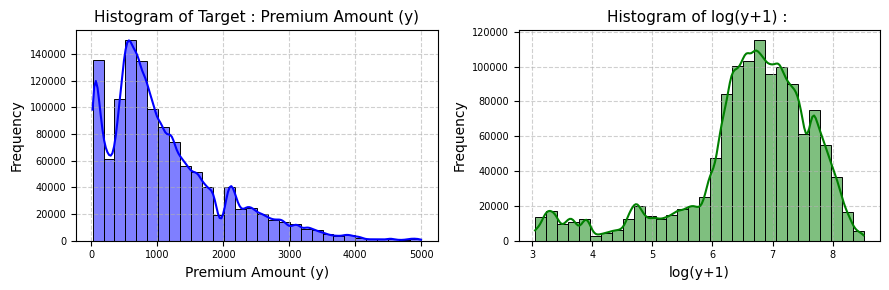

In [166]:
# 原始數據
plt.figure(figsize=(9,3))
plt.subplot(1, 2, 1)
sns.histplot(train[target_column], kde=True, bins=30, color="blue")
plt.title(f'Histogram of Target : {target_column} (y)', fontsize=11)
plt.xlabel(f'{target_column} (y)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)

# 對數變換後
y_train_log = np.log1p(train[target_column])
plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True, bins=30, color="green")
plt.title(f'Histogram of log(y+1) : ',fontsize=11)
plt.xlabel(f'log(y+1)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# EDA

In [167]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

# datetime transfer

In [168]:
datetime_columns = train.select_dtypes(include=['object']).columns

for col in datetime_columns:
    try:
        train[col] = pd.to_datetime(train[col],errors='raise')
        test[col] = pd.to_datetime(test[col],errors='raise')

        train[col] = train[col].astype(np.int64) / 10**9
        test[col] = train[col].astype(np.int64) / 10**9

        print(f'Coverted {col} to epoch time.')
    except Exception:
        continue

train.tail().T

Coverted Policy Start Date to epoch time.


id,1199995,1199996,1199997,1199998,1199999
Age,36.0,54.0,19.0,55.0,21.0
Gender,Female,Male,Male,Male,Female
Annual Income,27316.0,35786.0,51884.0,NaN,NaN
Marital Status,Married,Divorced,Divorced,Single,Divorced
Number of Dependents,0.0,NaN,0.0,1.0,0.0
Education Level,Master's,Master's,Master's,PhD,PhD
Occupation,Unemployed,Self-Employed,NaN,NaN,NaN
Health Score,13.772907,11.483482,14.724469,18.547381,10.125323
Location,Urban,Rural,Suburban,Suburban,Rural
Policy Type,Premium,Comprehensive,Basic,Premium,Premium


# missing value

In [169]:
train.isnull().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

# Visualizing missing value

In [170]:
def highlight_missing(val):
    if pd.isna(val):
        return 'background-color:SkyBlue; border: 1px solid red'
    else:
        return ''
# 他是篩選該col是否空的
columns_with_issues = train.columns[train.isnull().sum()>0]

# 把該col空的值取第一個代表性的行
representative_rows = pd.concat(
    [train[train[col].isnull()].iloc[:1] for col in columns_with_issues]
).drop_duplicates()

styled_df = representative_rows.T.style.applymap(highlight_missing)
display(styled_df)

id,83,22,45,14,1,6,11,15629,2,711358,28
Age,nan,22.000000,61.000000,40.000000,39.000000,41.000000,23.000000,25.000000,23.000000,64.000000,43.000000
Gender,Male,Male,Male,Female,Female,Male,Male,Female,Male,Male,Male
Annual Income,645.000000,nan,5095.000000,23897.000000,31678.000000,40336.000000,30983.000000,638.000000,25602.000000,30206.000000,1060.000000
Marital Status,Single,Divorced,nan,Divorced,Divorced,Married,Single,Divorced,Divorced,Married,Married
Number of Dependents,3.000000,4.000000,3.000000,nan,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,nan
Education Level,PhD,PhD,Master's,High School,Master's,PhD,Master's,PhD,High School,Master's,Master's
Occupation,Employed,nan,Employed,Self-Employed,nan,nan,nan,Employed,Self-Employed,Employed,Self-Employed
Health Score,30.766284,25.583790,40.886124,29.082036,15.569731,nan,5.813129,13.494674,47.177549,49.551038,41.376716
Location,Urban,Urban,Suburban,Suburban,Rural,Rural,Urban,Suburban,Suburban,Suburban,Suburban
Policy Type,Comprehensive,Comprehensive,Comprehensive,Basic,Comprehensive,Basic,Premium,Comprehensive,Premium,Basic,Premium


# filling missing value

In [171]:
numeric_columns = train.select_dtypes(include=['number']).columns
for col in numeric_columns:
    if col in test.columns:
        median_value = train[col].median()
        train[col].fillna(median_value,inplace=True)
        test[col].fillna(median_value,inplace=True)
object_columns = train.select_dtypes(include=['object']).columns
for col in object_columns:
    train[col].fillna('UnKnown',inplace=True)
    test[col].fillna('UnKnown',inplace=True)


In [172]:
train.isnull().sum()

Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

# Label Encoding for Categorical Features

In [173]:
le = LabelEncoder()
object_columns = train.select_dtypes(include=['object']).columns
for column_name in object_columns:
    train[column_name] = le.fit_transform(train[column_name])
    test[column_name] = le.transform(test[column_name])

In [174]:
train.dtypes

Age                     float64
Gender                    int64
Annual Income           float64
Marital Status            int64
Number of Dependents    float64
Education Level           int64
Occupation                int64
Health Score            float64
Location                  int64
Policy Type               int64
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date       float64
Customer Feedback         int64
Smoking Status            int64
Exercise Frequency        int64
Property Type             int64
Premium Amount          float64
dtype: object

# Dataset Normalization

In [175]:
numerical_columns = train.select_dtypes(include=['float64']).columns
numerical_columns = numerical_columns[ numerical_columns != target_column ]

scalar = StandardScaler()
train[numerical_columns] = scalar.fit_transform(train[numerical_columns])
test[numerical_columns] = scalar.transform(test[numerical_columns])

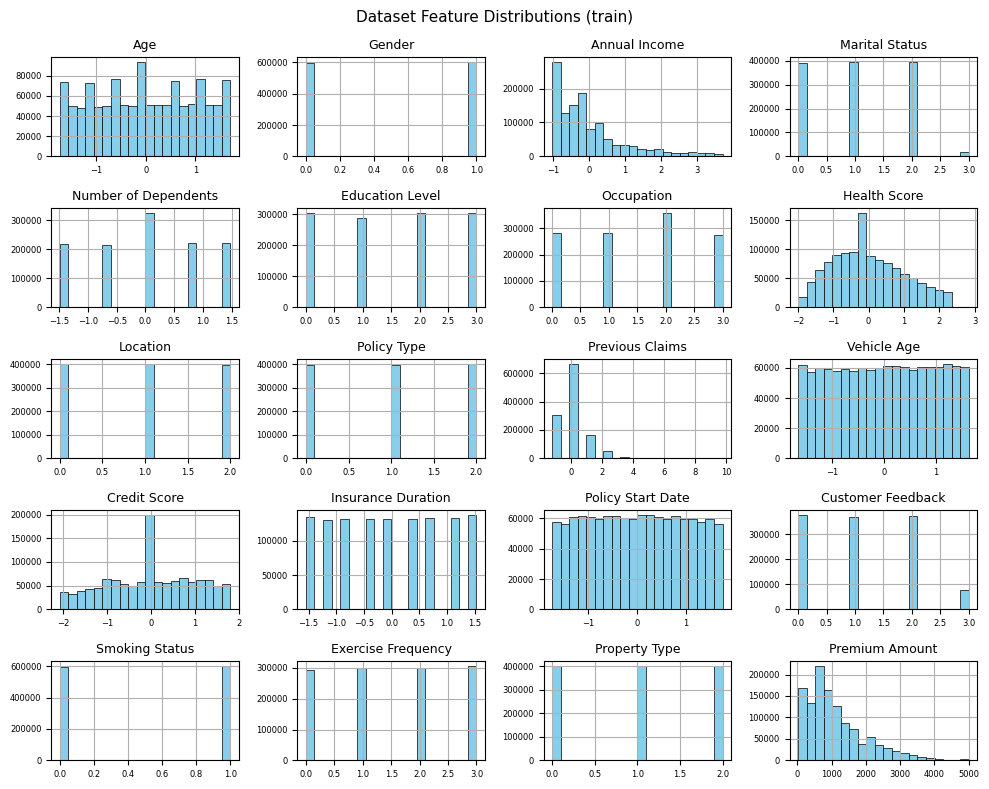

In [176]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))
columns_to_plot = train.columns
for i, column in enumerate(columns_to_plot):
    ax = axes.flatten()[i]
    train[column].hist(ax=ax, bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
    ax.set_title(column, fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=6)
plt.suptitle('Dataset Feature Distributions (train)', fontsize=11)
plt.tight_layout()
plt.show()

# Correlation Heap

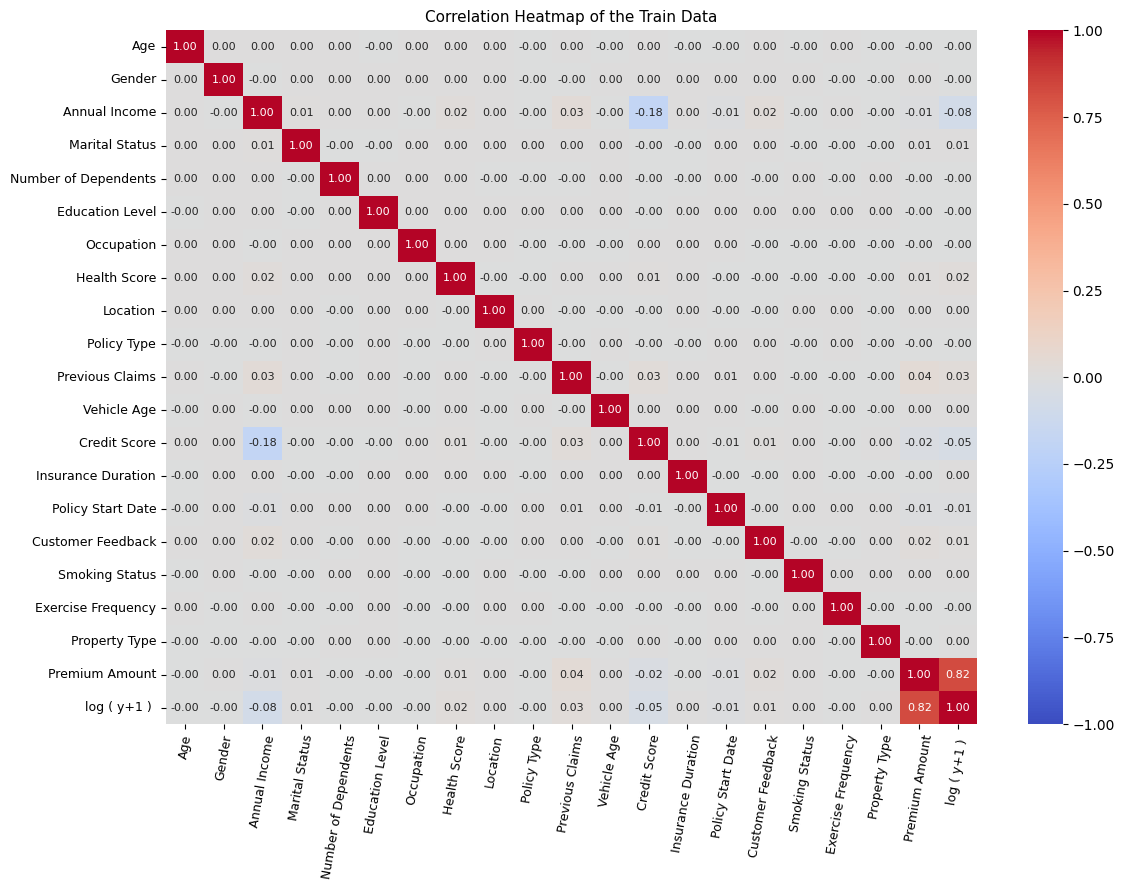

In [177]:
numeric_data = train.select_dtypes(include=['number'])
numeric_data['log ( y+1 ) '] = np.log1p(train[target_column])


correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmax=1, vmin=-1,
                      annot_kws={"size": 8}, fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=80, fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=9)

plt.title("Correlation Heatmap of the Train Data", fontsize=11)
plt.tight_layout()
plt.show()

# Training data

In [178]:
X_train = train.drop([target_column],axis=1)
y_train = train[target_column]
y_train_log = np.log1p(y_train)

display(X_train.dtypes, y_train.dtypes, y_train_log.dtypes)

Age                     float64
Gender                    int64
Annual Income           float64
Marital Status            int64
Number of Dependents    float64
Education Level           int64
Occupation                int64
Health Score            float64
Location                  int64
Policy Type               int64
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date       float64
Customer Feedback         int64
Smoking Status            int64
Exercise Frequency        int64
Property Type             int64
dtype: object

dtype('float64')

dtype('float64')

# Model

In [179]:
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator

class XGBRegressorWrapper(BaseEstimator):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)
    
    def set_params(self, **params):
        self.model.set_params(**params)
        return self


In [180]:
# Hyperparameters for BayesSearchCV tuning
search_spaces = {
    'n_estimators': (10, 200),      
    'max_depth': (3, 10),            
    'reg_alpha': (0.001, 0.2, 'log-uniform'),  
    'reg_lambda': (0.1, 100, 'log-uniform')     
}

# Set up BayesSearchCV for hyperparameter tuning
search = BayesSearchCV(
    estimator=XGBRegressorWrapper(random_state=42),
    search_spaces=search_spaces,
    n_iter=50,          # Number of iterations for optimization
    cv=5,               # k-fold cross-validation
    verbose=1,          # Display detailed logs
    scoring="neg_root_mean_squared_error",
    random_state=42     
)

# Perform the Bayesian optimization with cross-validation
search.fit(X_train, y_train_log)

print("Best params: ", search.best_params_)
print("Best RMSLE: ", -search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

# Prediction the Train target value

In [181]:
y_train_pred_log = search.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)

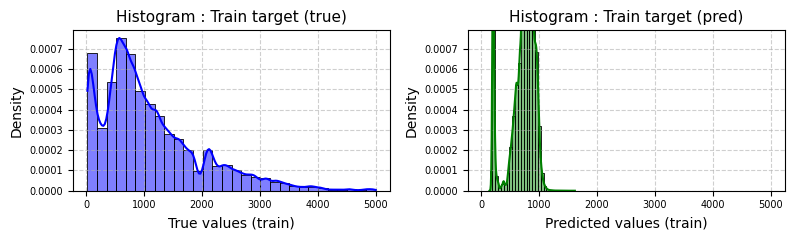

In [182]:
def plot_histogram(data, title, xlabel, color, x_limits=None, y_limits=None):
    sns.histplot(data, kde=True, bins=30, color=color, stat='density')
    plt.title(title, fontsize=11)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.grid(True, linestyle='--', alpha=0.6)
    if x_limits:
        plt.xlim(x_limits)
    if y_limits:
        plt.ylim(y_limits)

plt.figure(figsize=(12, 2.5))

# Plot 1: True values (train)
plt.subplot(1, 3, 1)
plot_histogram(y_train, title='Histogram : Train target (true)', xlabel='True values (train)', color='blue')
x_limits = plt.gca().get_xlim()
y_limits = plt.gca().get_ylim()

# Plot 2: Predicted values (train)
plt.subplot(1, 3, 2)
plot_histogram(y_train_pred, title='Histogram : Train target (pred)', 
               xlabel='Predicted values (train)', color='green', x_limits=x_limits, y_limits=y_limits)

plt.tight_layout()
plt.show()

# Scatter plot of true and pred 

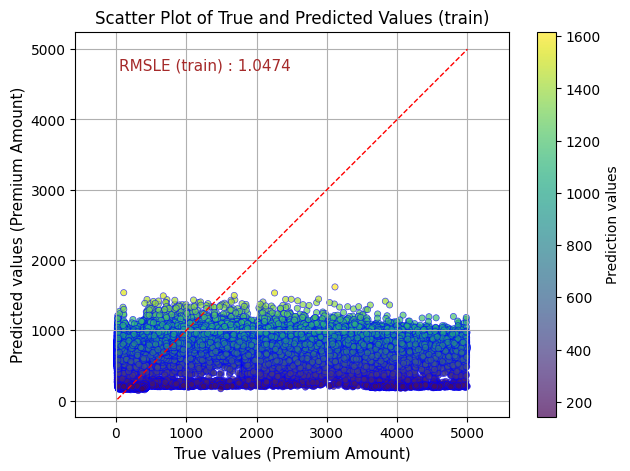

In [183]:
# Scatter Plot of True and Predicted Values (Training Target)
y_true = y_train
y_pred = y_train_pred

# Plot preparation
plt.figure(figsize=(7, 5))
plt.scatter(y_true, y_pred, c=y_pred, cmap='viridis', edgecolors='blue', s=20, alpha=0.7, linewidth=0.5)
cb = plt.colorbar()
cb.set_label('Prediction values')

# Plot the diagonal line
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=1.0)
plt.axis('equal')

# Add RMSLE text to the plot
rmsle_text = f'RMSLE (train) : {round(-search.best_score_, 4)}'
plt.text(0.10, 0.90, rmsle_text, transform=plt.gca().transAxes, fontsize=11, color='brown')

# Labels and title
plt.xlabel(f'True values ({target_column})', fontsize=11)
plt.ylabel(f'Predicted values ({target_column})', fontsize=11)
plt.title('Scatter Plot of True and Predicted Values (train)', fontsize=12)
plt.grid(True)
plt.show()

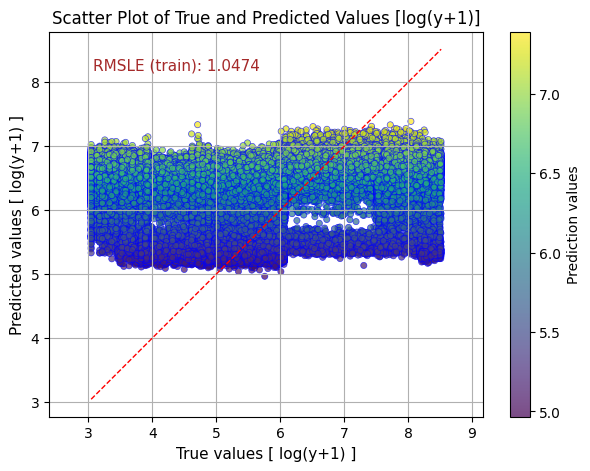

In [184]:
# Scatter Plot of True and Predicted Values [log(y+1)]
y_true = y_train_log
y_pred = y_train_pred_log

# Plot preparation
plt.figure(figsize=(7, 5))
plt.scatter(y_true, y_pred, c=y_pred, cmap='viridis', edgecolors='blue', s=20, alpha=0.7, linewidth=0.5)
cb = plt.colorbar()
cb.set_label('Prediction values')

# Plot the diagonal line
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=1.0)
plt.axis('equal')

# Add RMSLE text to the plot
rmsle_text = f'RMSLE (train): {round(-search.best_score_, 4)}'
plt.text(0.10, 0.90, rmsle_text, transform=plt.gca().transAxes, fontsize=11, color='brown')

# Labels and title
plt.xlabel('True values [ log(y+1) ]', fontsize=11)
plt.ylabel('Predicted values [ log(y+1) ]', fontsize=11)
plt.title('Scatter Plot of True and Predicted Values [log(y+1)]', fontsize=12)
plt.grid(True)
plt.show()

# Submission

In [185]:
y_test_pred_log = search.predict(test)     
y_test_pred = np.expm1(y_test_pred_log)

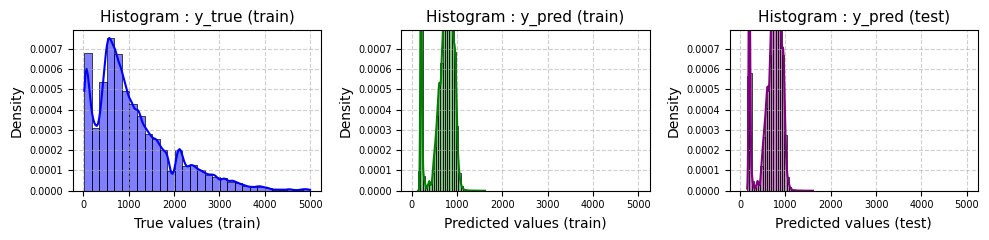

In [186]:
def plot_histogram(data, title, xlabel, color, x_limits=None, y_limits=None):
    sns.histplot(data, kde=True, bins=30, color=color, stat='density')
    plt.title(title, fontsize=11)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.grid(True, linestyle='--', alpha=0.6)
    if x_limits:
        plt.xlim(x_limits)
    if y_limits:
        plt.ylim(y_limits)

plt.figure(figsize=(10, 2.5))

# Plot 1: True values (train)
plt.subplot(1, 3, 1)
plot_histogram(y_train, title='Histogram : y_true (train)', xlabel='True values (train)', color='blue')
x_limits = plt.gca().get_xlim()
y_limits = plt.gca().get_ylim()

# Plot 2: Predicted values (train)
plt.subplot(1, 3, 2)
plot_histogram(y_train_pred, title='Histogram : y_pred (train)', 
               xlabel='Predicted values (train)', color='green', x_limits=x_limits, y_limits=y_limits)

# Plot 3: Predicted values (test)
plt.subplot(1, 3, 3)
plot_histogram(y_test_pred, title='Histogram : y_pred (test)', 
               xlabel='Predicted values (test)', color='purple', x_limits=x_limits, y_limits=y_limits)

plt.tight_layout()
plt.show()

In [188]:
# Create the submission DataFrame
submission = pd.DataFrame({'id': test.index, target_column: y_test_pred})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

submission

,id,Premium Amount
0,1200000,811.765625
1,1200001,837.634399
2,1200002,765.563965
3,1200003,772.071167
4,1200004,744.064697
...,...,...
799995,1999995,974.230835
799996,1999996,594.198242
799997,1999997,804.697632
799998,1999998,821.972290
